In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten, Dropout, Dense, Reshape, Conv2DTranspose
from keras.datasets import fashion_mnist 
from matplotlib import pyplot

Using TensorFlow backend.


In [23]:
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()
trainX = trainX/255.0
testX = testX/255.0

In [24]:
trainX = trainX.reshape((trainX.shape[0], 28,28,1))

In [25]:
trainX[0].shape

(28, 28, 1)

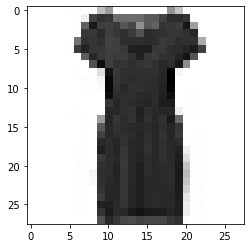

In [26]:
pyplot.imshow(trainX[20].reshape(28,28), cmap = 'gray_r')

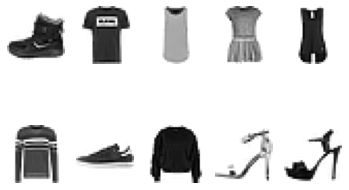

In [27]:
for i in range(10):
	# define subplot
	pyplot.subplot(2, 5, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i].reshape(28,28), cmap='gray_r')
pyplot.show()

In [59]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
 
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
 
	# compile model
	opt = tf.keras.optimizers.RMSprop(momentum=0.2)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
 
	return model

In [60]:
disc = define_discriminator()

In [61]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14 
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
 
  # we will not compile the generator as it is not trained directly.

	return model

In [62]:
gen = define_generator(50)

In [63]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False

	# connect them
	model = Sequential()
 
	# add generator
	model.add(generator)
 
	# add the discriminator
	model.add(discriminator)
 
	# compile model
	opt = tf.keras.optimizers.Adam(lr=0.002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [64]:
dcgan = define_gan(gen, disc)

In [65]:
from tqdm import tqdm
import numpy as np

In [67]:
for batch in tqdm(range(3)): # 3 is nom of epochs, it's recommened that nom of epochs be a small nomber 1,2 or 3
  d = 0
  for i in range(600):   #600 means that the training process will happen on the whole trainX which is 60000
    noise = tf.random.normal([100, 50]).numpy()   # 100 is the nom of samples per batch
    fake_faces = gen.predict(noise)

    real_faces = trainX[d : d + 100]
    batch = np.concatenate((real_faces, fake_faces))

    batch_size = len(fake_faces)
    y = np.concatenate((np.ones(batch_size), np.zeros(batch_size)))

    #train the discriminator
    history = disc.train_on_batch(batch, y)

    #train the generator
    dcgan.train_on_batch(noise, (np.ones(batch_size)))

    d += 100
  



  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:41<01:23, 41.74s/it]

 67%|██████▋   | 2/3 [01:22<00:41, 41.47s/it]

100%|██████████| 3/3 [02:03<00:00, 41.28s/it]


In [78]:
col_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

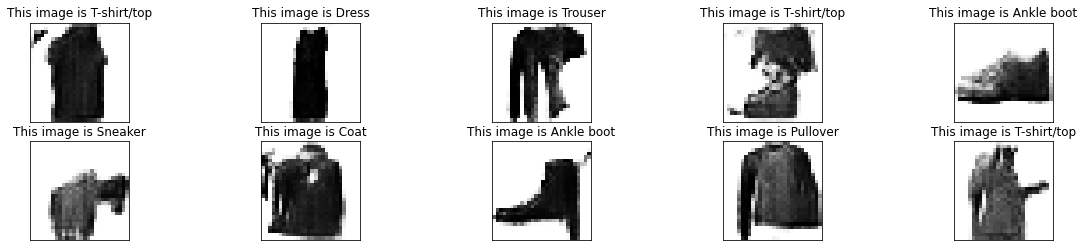

In [80]:
noise = tf.random.normal([10,50])
generated_image = gen.predict(noise)

n = len(generated_image)
fig = pyplot.figure(figsize=(20, 4))
ax = []
for i in range(0, n):
  ax.append(fig.add_subplot(2, 5, i+1))
  ax[-1].set_title("This image is " + str(col_names[np.argmax(fashion_predictor.predict(generated_image[i].reshape(1,28,28,1)))]))
  pyplot.imshow(generated_image[i, :, :, 0], cmap='gray_r')
  ax[-1].get_xaxis().set_visible(False)
  ax[-1].get_yaxis().set_visible(False)
  

In [82]:
gen.save('fashion_mnist_generator.h5')

In [71]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [72]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/My Drive/Kaggle'

In [76]:
%cd /content/gdrive/My Drive/Colab Notebooks/Epsilon notebooks/My DCGAN

/content/gdrive/My Drive/Colab Notebooks/Epsilon notebooks/My DCGAN


In [77]:
from tensorflow.keras.models import load_model
fashion_predictor = load_model('Fashion_mnist.h5')